In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# Data augmentation для тренування
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Для тесту лише нормалізація
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder("./train", transform=train_transform)
test_data  = datasets.ImageFolder("./test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

num_classes = len(train_data.classes)
print("Класи:", train_data.classes)

Класи: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [6]:
class CNN_Improved(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Improved, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 48→24
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24→12
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12→6
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128*6*6, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Improved(num_classes).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [9]:
def train_epoch(loader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(loader, leave=False)
    for X, y in loop:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

        loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    return total_loss / len(loader), correct / total

def test_epoch(loader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(loader, leave=False)
    with torch.no_grad():
        for X, y in loop:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

            loop.set_postfix(loss=loss.item(), accuracy=correct/total)

    return total_loss / len(loader), correct / total

In [10]:
epochs = 30
best_val_acc = 0
patience = 5
counter = 0

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = test_epoch(test_loader, model, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break


Epoch 1/30


Train Loss: 1.7418 | Train Acc: 0.3031 | Val Loss: 1.5150 | Val Acc: 0.4032

Epoch 2/30


Train Loss: 1.5256 | Train Acc: 0.4008 | Val Loss: 1.4212 | Val Acc: 0.4457

Epoch 3/30


Train Loss: 1.4514 | Train Acc: 0.4388 | Val Loss: 1.3274 | Val Acc: 0.4838

Epoch 4/30


Train Loss: 1.4045 | Train Acc: 0.4540 | Val Loss: 1.3075 | Val Acc: 0.5007

Epoch 5/30


Train Loss: 1.3639 | Train Acc: 0.4720 | Val Loss: 1.2699 | Val Acc: 0.5153

Epoch 6/30


Train Loss: 1.3430 | Train Acc: 0.4818 | Val Loss: 1.2139 | Val Acc: 0.5332

Epoch 7/30


Train Loss: 1.3194 | Train Acc: 0.4919 | Val Loss: 1.2055 | Val Acc: 0.5404

Epoch 8/30


Train Loss: 1.2985 | Train Acc: 0.4961 | Val Loss: 1.1805 | Val Acc: 0.5429

Epoch 9/30


Train Loss: 1.2754 | Train Acc: 0.5089 | Val Loss: 1.1877 | Val Acc: 0.5497

Epoch 10/30


Train Loss: 1.2553 | Train Acc: 0.5178 | Val Loss: 1.1486 | Val Acc: 0.5614

Epoch 11/30


Train Loss: 1.2505 | Train Acc: 0.5194 | Val Loss: 1.1424 | Val Acc: 0.5642

Epoch 12/30


Train Loss: 1.2342 | Train Acc: 0.5270 | Val Loss: 1.1311 | Val Acc: 0.5694

Epoch 13/30


Train Loss: 1.2162 | Train Acc: 0.5330 | Val Loss: 1.1318 | Val Acc: 0.5720

Epoch 14/30


Train Loss: 1.2046 | Train Acc: 0.5391 | Val Loss: 1.1101 | Val Acc: 0.5800

Epoch 15/30


Train Loss: 1.1942 | Train Acc: 0.5455 | Val Loss: 1.1082 | Val Acc: 0.5766

Epoch 16/30


Train Loss: 1.1809 | Train Acc: 0.5473 | Val Loss: 1.1113 | Val Acc: 0.5798

Epoch 17/30


Train Loss: 1.1668 | Train Acc: 0.5549 | Val Loss: 1.0967 | Val Acc: 0.5861

Epoch 18/30


Train Loss: 1.1547 | Train Acc: 0.5601 | Val Loss: 1.0906 | Val Acc: 0.5936

Epoch 19/30


Train Loss: 1.1468 | Train Acc: 0.5638 | Val Loss: 1.0840 | Val Acc: 0.5957

Epoch 20/30


Train Loss: 1.1307 | Train Acc: 0.5691 | Val Loss: 1.0790 | Val Acc: 0.5931

Epoch 21/30


Train Loss: 1.1230 | Train Acc: 0.5711 | Val Loss: 1.0681 | Val Acc: 0.5952

Epoch 22/30


Train Loss: 1.1104 | Train Acc: 0.5755 | Val Loss: 1.0592 | Val Acc: 0.5982

Epoch 23/30


Train Loss: 1.0937 | Train Acc: 0.5852 | Val Loss: 1.0902 | Val Acc: 0.5907

Epoch 24/30


Train Loss: 1.0870 | Train Acc: 0.5864 | Val Loss: 1.0698 | Val Acc: 0.5869

Epoch 25/30


Train Loss: 1.0733 | Train Acc: 0.5950 | Val Loss: 1.0642 | Val Acc: 0.5995

Epoch 26/30


Train Loss: 1.0578 | Train Acc: 0.5975 | Val Loss: 1.0476 | Val Acc: 0.6059

Epoch 27/30


Train Loss: 1.0492 | Train Acc: 0.6015 | Val Loss: 1.0465 | Val Acc: 0.6010

Epoch 28/30


Train Loss: 1.0354 | Train Acc: 0.6061 | Val Loss: 1.1145 | Val Acc: 0.5965

Epoch 29/30


Train Loss: 1.0236 | Train Acc: 0.6152 | Val Loss: 1.0388 | Val Acc: 0.6119

Epoch 30/30


Train Loss: 1.0119 | Train Acc: 0.6158 | Val Loss: 1.0436 | Val Acc: 0.6094


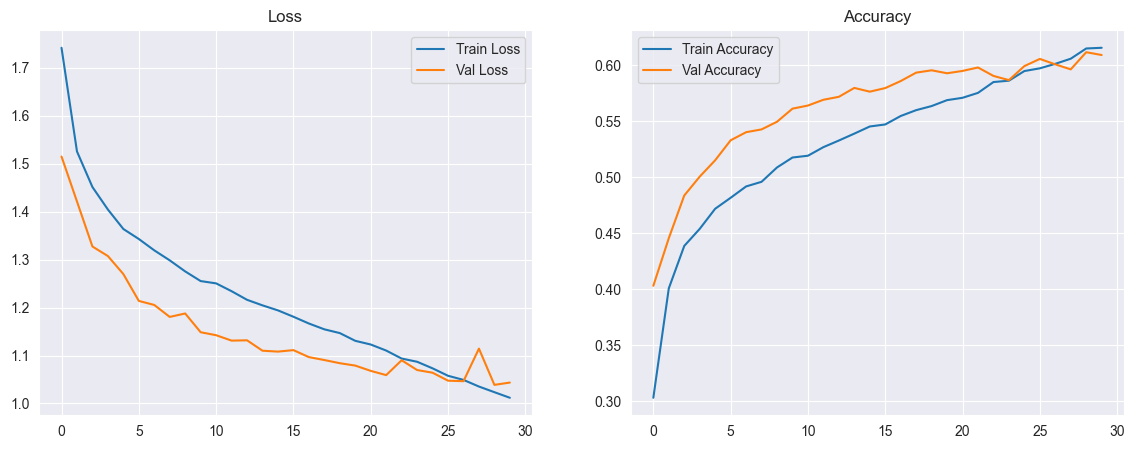

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()